# Saint James No-Show Analysis

This notebook analyses the no-shows at Saint James to see if there are any trends regarding who will and won't show up to a booking from Janurary to June 2023.

Key takeaways include:  

In [ ]:
# imports key libraries
import pandas as pd
import numpy as np

# creates a local link to the archive spreadsheet object
archive = 'C:/Users/HUAWEI/Desktop/Projects/SJ-No-Show-Analysis/Data/Archive.xlsx'

# creats a list of archive sheet names
check_out_sheets = ['NO SHOW JAN ', 'NO SHOW FEB', 'NO SHOW', 'NO SHOW APR', 'NO SHOW MAY', 'NO SHOW JUN']

# reads-in a list of archive check-out sheets
check_out_dfs = []
for i in range(len(check_out_sheets)):
    check_out_dfs.append(pd.read_excel(archive, check_out_sheets[i]))
    
# creates a column names object
check_outs_col_names = ['Check-in', 'Check-out', 'Nights', 'Guests', 'room', 'room_1', 'name', 'Price', 'paid', 'Booking Type', 'KD cash', 'KD card', 'comment', 'payment status', 'Checked status']

# changes the column names for each sheet
for i in range(len(check_out_dfs)):
    check_out_dfs[i].columns = check_outs_col_names
    
# joins each check-out sheet together to create a single check-out dataframe
check_out_df = pd.concat(check_out_dfs)

# saves the check-out dataframe so that changes can be made on the spreadsheet in preparation for data cleaning
check_out_df.to_excel('Data/check_out_df.xlsx') 

# prints the first 6 rows of the new check-out dataframe
check_out_df.head(6)

## 1) Data cleaning

### Locate non-blank rows

In [42]:
# reads in the combined check-out dataframe
check_out_df = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/SJ-No-Show-Analysis/Data/check_out_df.xlsx')

# creates an index object denoting which rows are non-NA and therefore valid rows
col = check_out_df['Check-in']
index = []
for i in range(len(col)):
    try:
        col[i].year
        index.append(i)
    except:
        pass

# resets the check-out dataframe to non-NA rows
check_out_df = check_out_df.iloc[index,:].reset_index(drop=True)

# creates a new dataframe including only non-NA rows for the first 3 columns
clean_check_out_df = pd.DataFrame()
check_out_df = check_out_df[pd.isna(check_out_df.iloc[:,0:1]).sum(axis=1)==0].reset_index(drop=True)

### Separate check-in dates

In [44]:
# imports necessary libraries
import datetime as dt
import statistics as stats

# makes sure no NA values are passed through into the clean dataset
def get_col(df, col_name, dot_method=None):
    col = df[col_name]
    values = []
    for i in range(len(col)):
        try:
            if dot_method != None:
                values.append(eval('df[col_name][i]' + dot_method))
            else:
                values.append(df[col_name][i])
        except:
            pass
    return [i for i in values if pd.isna(i) == False]

# creates seperate columns for the check-in year, month and day
clean_check_out_df['In-Year'] = get_col(check_out_df, 'Check-in', '.year')
clean_check_out_df['In-Month'] = get_col(check_out_df, 'Check-in', '.month')
clean_check_out_df['In-Day'] = get_col(check_out_df, 'Check-in', '.day')

### Separate check-out dates

In [45]:
# creates an NA free nights column to be added to the check-in date to calcuate check-out
nights = get_col(check_out_df, 'Nights')
check_in = get_col(check_out_df, 'Check-in')

# adds nights to check-in to determine check-out
check_out = []
for i in range(len(nights)):
    check_out.append(check_in[i] + dt.timedelta(days = nights[i]))
    
# creates a new dataframe object containing check-outs data
check_out = pd.DataFrame({'check_out': check_out})

# creates 3 seperate columns for the check-outs year, month and day
clean_check_out_df['Out-Year'] = get_col(check_out, 'check_out', '.year')
clean_check_out_df['Out-Month'] = get_col(check_out, 'check_out', '.month')
clean_check_out_df['Out-Day'] = get_col(check_out, 'check_out', '.day')

### View NAs

In [46]:
# creates a cols object for looping
cols = ['Nights', 'Guests', 'room', 'Price', 'Booking Type', 'KD cash', 'KD card', 'payment status', 'Checked status']

# creates a length object for calculating NA percentages
total = len(check_out_df)

# calculates total NAs and NA percentages
NAs = []
percent = []
for i in range(len(cols)):
    NAs.append(sum(check_out_df[cols[i]].isna()))
    percent.append((round(sum(check_out_df[cols[i]].isna()) / total, 3))*100)

# displays NA counts and percentages as a dataframe
pd.DataFrame({'Column': cols, 'NA Count': NAs, 'Percent (%)': percent})

,Column,NA Count,Percent (%)
0,Nights,0,0.0
1,Guests,0,0.0
2,room,0,0.0
3,Price,0,0.0
4,Booking Type,0,0.0
5,KD cash,165,100.0
6,KD card,162,98.2
7,payment status,0,0.0
8,Checked status,35,21.2


### Fill NAs

In [47]:
# assigns the nights object as the nights column
clean_check_out_df['Nights'] = nights

# fills missing guests values with the median
clean_check_out_df['Guests'] = check_out_df['Guests'].fillna(stats.median(check_out_df['Guests']))

# fills missing room values with room 21
clean_check_out_df['Room'] = check_out_df['room'].fillna(21)

# fills missing price values in with the median price
clean_check_out_df['Price'] = check_out_df['Price'].fillna(stats.median(check_out_df['Price']))

# fills missing booking type values with booking vc
clean_check_out_df['Booking Type'] = check_out_df['Booking Type'].str.lower().fillna('Booking VC')

# fills missing kd cash and card values with 0 
clean_check_out_df['KD Cash'] = check_out_df['KD cash'].fillna(0)
clean_check_out_df['KD Card'] = check_out_df['KD card'].fillna(0)

# fills missing payment status values with 'none'
clean_check_out_df['Payment Status'] = check_out_df['payment status'].str.lower().fillna('none')

# creates a binary column where an NA value is assumed to mean the booking was not checked
clean_check_out_df['Booking Checked'] = [1 if i is not True else 0 for i in check_out_df['Checked status'].isna()]

## 2) Transformations

### Transform standard columns

In [48]:
# bookings each month
by_months = clean_check_out_df['In-Month'].value_counts().sort_index().iloc[0:7]

# bookings by number of nights
by_nights = clean_check_out_df['Nights'].value_counts().sort_index().iloc[0:10]

# bookings by number of guests
by_guests = clean_check_out_df['Guests'].value_counts().sort_index().iloc[0:5]

# bookings by individual rooms
by_room = clean_check_out_df['Room'].astype(str).value_counts().sort_index()

# months by total price in thousands
by_price = round(clean_check_out_df.groupby('In-Month').sum()['Price'].iloc[0:7:] / 1000, 1)

### Transform % of bookings

In [180]:
# lists total bookings each month
total_bookings = [495, 505, 625, 649, 763, 876]

# divides no shows by total bookings to get no shows as a percent of bookings 
by_percent_bookings = (by_months / total_bookings) * 100

### Transform room type

In [55]:
# filters out problematic values
problems = ['03/21', '1900-01-04 00:00:00', '2025-04-01 00:00:00']
index = [True if i not in problems else False for i in by_room.index]
by_room = by_room[index]

# creates lists of rooms for each room type
private = ['A', 'B', 'C', '30', '31', '37']
eight_bed = ['3', '4', '21', '24']
female = ['2', '5', '23']
six_bed = ['36', '32']
four_bed = ['33', '34', '35']
triple = ['1', '6', '20', '25']

# loops through the by room summary and assigns a room type to the room_type object
room_type = []
for  i in range(len(by_room)):
    if by_room.index[i] in private:
        room_type.append('Private')
    elif by_room.index[i] in eight_bed:
        room_type.append('8 bed')
    elif by_room.index[i] in female:
        room_type.append('Female')
    elif by_room.index[i] in six_bed:
        room_type.append('6 bed')
    elif by_room.index[i] in four_bed:
        room_type.append('4 bed')
    elif by_room.index[i] in triple:
        room_type.append('Triple')
    else:
        room_type.append('Multiple')

# creates a dataframe of rooms, counts and types
room_df = pd.DataFrame({'Room': by_room.index, 'Count': by_room, 'Type': room_type}).reset_index(drop=True)

# sorts the data by value count
by_room = room_df.Count.sort_values(ascending=False)
by_room.index = room_df.Room

# sums the data after grouping by room type and reverses the order to be descending
by_room_type = room_df[['Count', 'Type']].groupby('Type').sum().iloc[:,0].sort_values(ascending=True)
by_room_type = by_room_type[::-1]

### Transform booking type

In [50]:
# removes extra whitespace
clean_check_out_df['Booking Type'] = [x.strip() for x in clean_check_out_df['Booking Type']]

# converts mispelled booking vcs 
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'booking', 'Booking Type'] = 'booking vc'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'bookin vc', 'Booking Type'] = 'booking vc'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'bookingvcd', 'Booking Type'] = 'booking vcd'

# converts mispelled expedia vcns 
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'expediavcn', 'Booking Type'] = 'expedia vcn'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'expediavcn', 'Booking Type'] = 'expedia vcn'

# converts group booking to group for concision
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'group booking', 'Booking Type'] = 'group'

# converts trip.com entries into trip for concision
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'trip', 'Booking Type'] = 'trip vc'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'trip.com', 'Booking Type'] = 'trip vc'

# converts mispelled walk-ins 
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walk ', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walk', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'wak-in', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walk in', 'Booking Type'] = 'walk-in'
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'walkin', 'Booking Type'] = 'walk-in'

# converts weekly rate to weekly for concision
clean_check_out_df.loc[clean_check_out_df['Booking Type'] == 'weekly rate', 'Booking Type'] = 'weekly'

# converts to lower, counts values and sorts in descending order
by_booking_type = clean_check_out_df['Booking Type'].str.lower().value_counts().sort_values(ascending=False)

### Transform booking provider

In [51]:
# assigns different booking types to a booking_provider object
booking_provider = []
for i in range(len(clean_check_out_df)):
    if 'ooking' in clean_check_out_df['Booking Type'][i]:
        booking_provider.append('booking')
    elif 'expedia' in clean_check_out_df['Booking Type'][i]:
        booking_provider.append('expedia')
    elif 'trip' in clean_check_out_df['Booking Type'][i]:
        booking_provider.append('trip')
    else:
        booking_provider.append(clean_check_out_df['Booking Type'][i])

# creates a new booking provider column in the clean dataframe
clean_check_out_df['Booking provider'] = booking_provider

# counts different booking provider types and converts the index to title
by_booking_provider = clean_check_out_df['Booking provider'].value_counts().iloc[0:6]
by_booking_provider.index = by_booking_provider.index.str.title()

### Transform paid

In [161]:
# lists all the mispellings of paid
paid_mispellings = ['paind', 'paid  ', 'paid by paynow', 'paud ', 'piad', 'paid paynow',
                    'paid with paynow', 'oaid', 'paid  paynow', 'paid   ', 
                    ' paid', 'paidl', 'paynow', 'paif', 'paid by pay now', 'paid ']

# converts all instances of paid mispellings to paid
for i in range(len(clean_check_out_df)):
    if clean_check_out_df['Payment Status'][i] in paid_mispellings:
        clean_check_out_df['Payment Status'][i] = 'paid'

#  creates two binary lists indicating paid or not paid
paid = []
not_paid = []
for i in range(len(clean_check_out_df)):
    if clean_check_out_df['Payment Status'][i] == 'paid':
        paid.append(1)
        not_paid.append(0)
    else:
        paid.append(0)
        not_paid.append(1)

# creates two new binary columns in the dataframe indicating paid and not paid
clean_check_out_df['paid'] = paid
clean_check_out_df['not paid'] = not_paid

# sums paid and not paid by month and then calculates a paid ratio
paid_months = clean_check_out_df[['In-Month', 'paid']].groupby('In-Month').sum().iloc[0:7].squeeze()
not_paid_months = clean_check_out_df[['In-Month', 'not paid']].groupby('In-Month').sum().iloc[0:7].squeeze()
by_payment_mistakes = round((not_paid_months / (paid_months+not_paid_months))*100,2)

# creates a price not paid measure
by_price_not_paid = by_price * (by_payment_mistakes/100)

### Transform dates to weekdays

In [52]:
# takes in the date and gives back the day of the week
def calculate_day_of_week(year, month, day):
    try:
        # Create a datetime object for the given date
        date_obj = dt.datetime(year, month, day)
        # Get the day of the week as an integer (Monday is 0 and Sunday is 6)
        day_of_week = date_obj.weekday()
        
        return day_of_week
    except ValueError as e:
        return str(e)

# calculates the day of the week for each booking in the dataframe
weekdays = []
for i in range(len(clean_check_out_df)):
    year = clean_check_out_df['In-Year'][i]
    month = clean_check_out_df['In-Month'][i]
    day = clean_check_out_df['In-Day'][i]
    weekdays.append(calculate_day_of_week(year, month, day))
    
# creates a weekdays column
clean_check_out_df['weekday'] = weekdays

# counts weekdays and sorts the index
by_weekday = clean_check_out_df['weekday'].value_counts().sort_index()

## 3) Vizualizations

### Financial overview

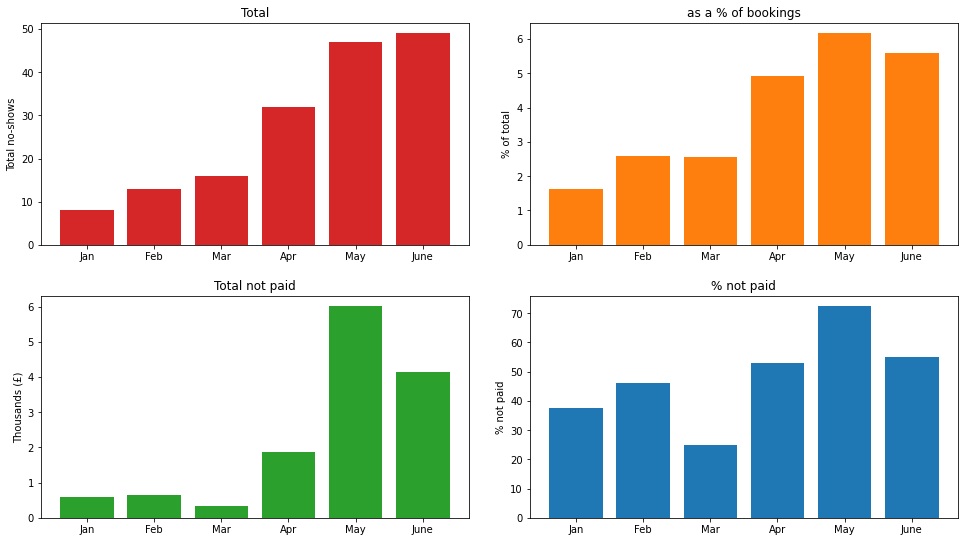

In [187]:
import matplotlib.pyplot as plt 

plots = [ 'by_months', 'by_payment_mistakes', 'by_price_not_paid', 'by_percent_bookings']

titles = ['Total', '% not paid', 'Total not paid', 'as a % of bookings']

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June']

days = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]

xticks = [months, months, months, months]

ylabs = ['Total no-shows', '% not paid', 'Thousands (£)', '% of total']

colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

length = len(plots)
cols = 2
rows = int(np.ceil(length / cols))

fig, ax = plt.subplots(rows, cols, figsize=(14,8));
fig.tight_layout(pad=3.0);
for i in range(rows):
    for j in range(cols):
        num = (i*rows)-j
        ax[i, j].bar(eval(plots[num]).index, eval(plots[num]), color=colors[num]);
        ax[i, j].set_title(titles[num]);
        ax[i, j].set_xticks(eval(plots[num]).index, labels=xticks[num]);
        ax[i, j].set_ylabel(ylabs[num]);

### Customer type overview

In [ ]:
import matplotlib.pyplot as plt 

plots = ['by_nights', 'by_guests', 'by_weekday', 'by_room_type', 'by_booking_provider']

titles = ['No. of Nights Stayed', 'No. of Guests', 'Total Bookings', 'Day of the Week', 'Room Type', 'Booking Providers', '% not paid']

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June']

days = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]

providers = ['Booking', 'Walk-in', 'HW', 'Expedia', 'BB', 'Trip']

xticks = [None, None, months, days, None, providers, months]

ylabs = ['Bookings', 'Bookings', 'Bookings', 'Bookings', 'Bookings', 'Bookings', '% not paid']

colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:brown']

length = len(plots)
cols = 3
rows = int(np.ceil(length / cols))

fig, ax = plt.subplots(rows, cols, figsize=(15,8))
fig.tight_layout(pad=3.0);
for i in range(rows):
    for j in range(cols):
        num = (((i+1)*3)-j)-1
        ax[i, j].bar(eval(plots[num]).index, eval(plots[num]), color=colors[num]);
        ax[i, j].set_title(titles[num]);
        ax[i, j].set_xticks(eval(plots[num]).index, labels=xticks[num]);
        ax[i,j].set_ylabel(ylabs[num]);